In [14]:
'''
Used provided example code to help work through this section of the assignment
https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a
'''

import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [7]:
!gdown https://drive.google.com/uc?id=1dA2sm3DjRLQNY13uCdvXja79LcCq3kt1
!gdown https://drive.google.com/uc?id=1OsQO3pAUgifbWO-YjGe5OrMqL3Sf_8zF
!gdown https://drive.google.com/uc?id=1HmvcSX7YF3gS-RK4dCP0fQi6i7SjsJ8g

Downloading...
From (original): https://drive.google.com/uc?id=1dA2sm3DjRLQNY13uCdvXja79LcCq3kt1
From (redirected): https://drive.google.com/uc?id=1dA2sm3DjRLQNY13uCdvXja79LcCq3kt1&confirm=t&uuid=98113732-1782-49a4-8104-2cb1c83dbc2e
To: C:\Users\jaren\OneDrive\Documents\University\CSC420\a2\SDDsubset.zip

  0%|          | 0.00/45.2M [00:00<?, ?B/s]
  1%|1         | 524k/45.2M [00:00<00:09, 4.51MB/s]
 14%|#3        | 6.29M/45.2M [00:00<00:01, 32.1MB/s]
 30%|###       | 13.6M/45.2M [00:00<00:00, 49.5MB/s]
 42%|####1     | 18.9M/45.2M [00:00<00:00, 48.4MB/s]
 57%|#####6    | 25.7M/45.2M [00:00<00:00, 54.7MB/s]
 72%|#######1  | 32.5M/45.2M [00:00<00:00, 58.1MB/s]
 87%|########6 | 39.3M/45.2M [00:00<00:00, 59.4MB/s]
100%|##########| 45.2M/45.2M [00:00<00:00, 53.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OsQO3pAUgifbWO-YjGe5OrMqL3Sf_8zF
From (redirected): https://drive.google.com/uc?id=1OsQO3pAUgifbWO-YjGe5OrMqL3Sf_8zF&confirm=t&uuid=0d035fcd-af13-4bcb-90a6-f216de

In [11]:
import zipfile
with zipfile.ZipFile("./SDDsubset.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
with zipfile.ZipFile("./DBIsubset.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
with zipfile.ZipFile("./task5.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


In [12]:
# TASK II

In [15]:
dataset = ImageFolder('./DBIsubset')
breeds = []

for n in dataset.classes:
    breeds.append(n)

len(dataset)

646

In [16]:
random_seed = 45
torch.manual_seed(random_seed);

test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train_size, val_size, test_size

(408, 45, 193)

In [17]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(408, 45, 193)

3


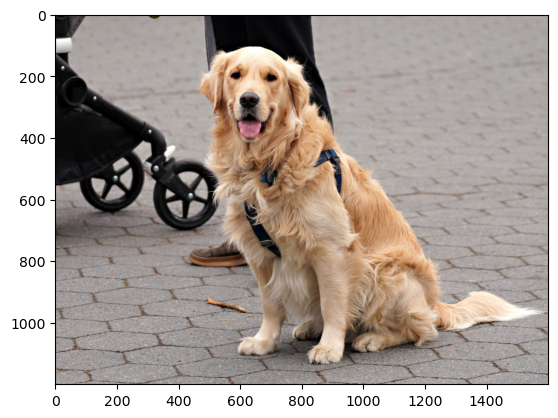

In [6]:
img, label = train_ds[6]
print(label)
plt.imshow(img)

In [7]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [8]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [9]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

3


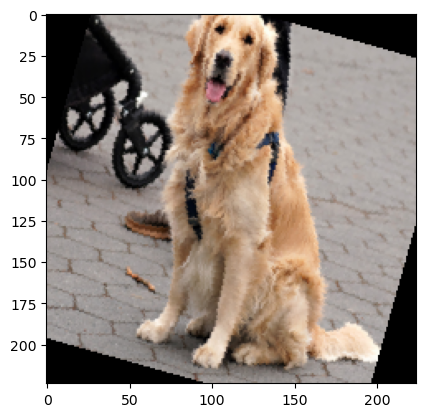

In [10]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

3


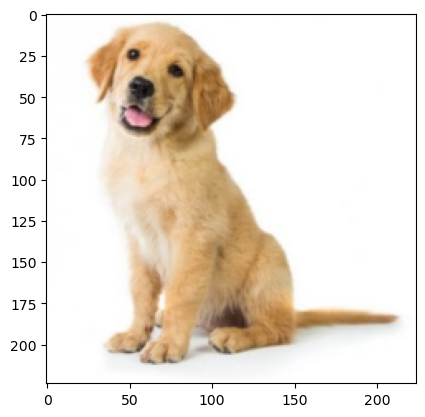

In [11]:
img, label = val_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [12]:
batch_size =64

# Create DataLoaders
# I was getting runtime errors and after some online searching, it suggested making the following changes:
# - set batch size to 1
# - set num_workers to 0 to avoid parallel work
# So I am documenting this here in case it affects expected results; I had to make those changes for the code to run

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*1, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*1, num_workers=0, pin_memory=True)

In [13]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'train_acc':acc.detach(), 'train_loss':loss}
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["train_acc"], result["val_loss"], result["val_acc"]))
        

In [16]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self, train_with_dropout):
        super().__init__()
        self.train_with_dropout = train_with_dropout
        
        if train_with_dropout:
            self.network = nn.Sequential(
                # note to self: check if error occurs here since we are changing his parameters
                # all kernel sizes set to 3
                nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 244 * 16
                nn.BatchNorm2d(16),
                nn.ReLU(),                                   
                nn.Conv2d(16, 16, 3, stride=1, padding=1),       
                nn.ReLU(),
                nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
                # 16 comes in from last layer and we change it to 8
                nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112* 64
                nn.BatchNorm2d(8),
                nn.ReLU(), 
                nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
                nn.ReLU(),
                nn.MaxPool2d(2,2),                          # 56 * 56* 8
                nn.Dropout(0.5),  
                nn.Flatten(),
                nn.Linear(8*56*56, 32),                     # fully connected 32 
                nn.ReLU(),
                nn.Dropout(0.5),  
                nn.LogSoftmax(dim = 1)
            )
        else:
            self.network = nn.Sequential(
                # note to self: check if error occurs here since we are changing his parameters
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),   # 224 * 244 * 16
                nn.BatchNorm2d(16),
                nn.ReLU(),                                   
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),       
                nn.ReLU(),
                nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
                # 16 comes in from last layer and we change it to 8
                nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112* 64
                nn.BatchNorm2d(8),
                nn.ReLU(), 
                nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
                nn.ReLU(),
                nn.MaxPool2d(2,2),                          # 56 * 56* 8
                nn.Flatten(),
                nn.Linear(8*56*56, 32),                     # fully connected 32 
                nn.ReLU(),
                nn.LogSoftmax(dim = 1)
            )
            
    
    def forward(self, xb):
        return self.network(xb)

In [17]:
with_drop = True
model_with_dropout = DogBreedClassificationCNN(with_drop)
model_without_dropout = DogBreedClassificationCNN(not with_drop)
model_with_dropout, model_without_dropout

(DogBreedClassificationCNN(
   (network): Sequential(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): ReLU()
     (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU()
     (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (10): ReLU()
     (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (12): Dropout(p=0.5, inplace=False)
     (13): Flatten(start_dim=1, end_dim=-1)
     (14): Linear(in_features=25088, out_features=32, bias=True)
     (15): ReLU()
     (16): Dropout(p=0.5, inplace=False)
     (17): LogSoft

In [18]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [19]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [20]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader and test dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# moving model to gpu
to_device(model_without_dropout, device)
to_device(model_with_dropout, device)

cuda


DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.5, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=25088, out_features=32, bias=True)
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): LogSoftmax(dim=1)
  )
)

In [21]:
from tqdm.notebook import tqdm

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        train_accs = []
        lrs = []
        for batch in tqdm(train_loader):
            loss_and_acc = model.training_step(batch)
            train_accs.append(loss_and_acc['train_acc'])
            train_losses.append(loss_and_acc['train_loss'])
            
            # calculates gradients
            loss_and_acc['train_loss'].backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [23]:
evaluate(model_with_dropout, test_dl)  

{'val_loss': 3.471168041229248, 'val_acc': 0.0}

In [24]:
evaluate(model_without_dropout, test_dl)

{'val_loss': 3.4635684490203857, 'val_acc': 0.0}

In [25]:
# set hyperparams
# set back to 10 for submission
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [26]:
history_with_dropout = fit_one_cycle(num_epochs, max_lr, model_with_dropout, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.3773, train_acc: 0.0848, val_loss: 3.3109, val_acc: 0.0742


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 3.2940, train_acc: 0.1704, val_loss: 3.1823, val_acc: 0.0820


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 3.1466, train_acc: 0.2083, val_loss: 3.1652, val_acc: 0.0977


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 3.0389, train_acc: 0.1920, val_loss: 2.8744, val_acc: 0.4180


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 3.0191, train_acc: 0.2426, val_loss: 2.8705, val_acc: 0.4258


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 3.0426, train_acc: 0.2054, val_loss: 2.8798, val_acc: 0.4219


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 2.9191, train_acc: 0.2671, val_loss: 2.3170, val_acc: 0.4180


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 2.8783, train_acc: 0.2656, val_loss: 2.5277, val_acc: 0.4180


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 2.8862, train_acc: 0.2671, val_loss: 2.4377, val_acc: 0.4258


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 3.0124, train_acc: 0.2500, val_loss: 2.4848, val_acc: 0.4336


In [27]:
history_without_dropout = fit_one_cycle(num_epochs, max_lr, model_without_dropout, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 2.9674, train_acc: 0.1503, val_loss: 3.1495, val_acc: 0.0820


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 2.6437, train_acc: 0.1615, val_loss: 2.1059, val_acc: 0.0820


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.8748, train_acc: 0.3348, val_loss: 2.2842, val_acc: 0.2031


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.6033, train_acc: 0.3802, val_loss: 2.0454, val_acc: 0.2500


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.6004, train_acc: 0.3899, val_loss: 1.8184, val_acc: 0.2227


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.5030, train_acc: 0.4189, val_loss: 1.6027, val_acc: 0.4727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.4512, train_acc: 0.4576, val_loss: 1.5173, val_acc: 0.5234


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.4160, train_acc: 0.4695, val_loss: 1.5446, val_acc: 0.5039


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.3540, train_acc: 0.4784, val_loss: 1.5405, val_acc: 0.4922


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.3093, train_acc: 0.4948, val_loss: 1.5376, val_acc: 0.5078


In [28]:
history_with_dropout[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'train_acc', 'lrs'])

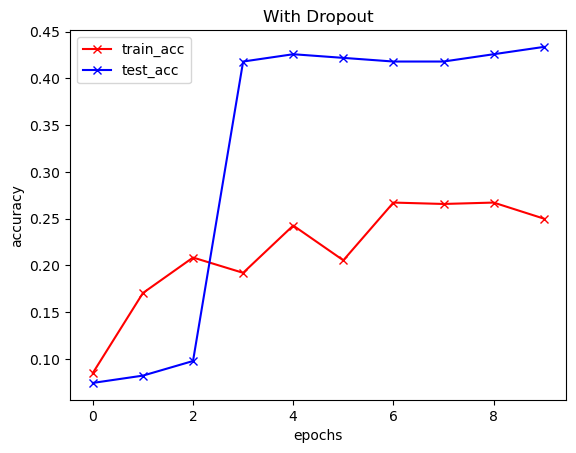

In [29]:
# I am assuming here that the val refers to test since that is what I initialized the epochs with, and it is showing as
# val because of how the guy implemented his CNN
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_with_dropout)))
for h in history_with_dropout:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.title('With Dropout')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

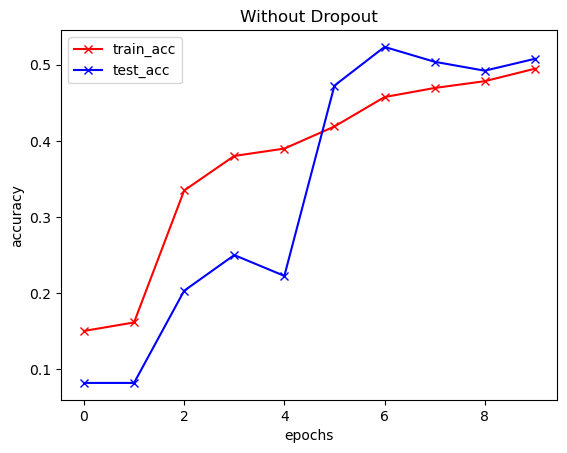

In [30]:
# I am assuming here that the val refers to test since that is what I initialized the epochs with, and it is showing as
# val because of how the guy implemented his CNN
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_without_dropout)))
for h in history_without_dropout:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.title('Without Dropout')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [31]:
# Task III.a

In [32]:
# C:\Users\jaren\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter "pretrained" is deprecated since 0.13 
# and may be removed in the future, please use "weights" instead.
# warnings.warn(
# C:\Users\jaren\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 
# "weights" are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
# warnings.warn(msg)

class DogBreedUntrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(weights=None) # do not use the pre-trained ResNet. originally pretrained=False but changed on error message above
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32), # assuming we need 32 filters since it is the largest in the network definition (in fully connected (32) )
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [33]:
modelResNet_18 = DogBreedUntrainedResnet18()
modelResNet_18

DogBreedUntrainedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [34]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# moving model to gpu
to_device(modelResNet_18, device)

cuda


DogBreedUntrainedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [35]:
evaluate(modelResNet_18, test_dl)

{'val_loss': 3.2877824306488037, 'val_acc': 0.0}

In [36]:
# train with validation first
history_ResNet18_validation = fit_one_cycle(num_epochs, max_lr, modelResNet_18, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.0991, train_acc: 0.0506, val_loss: 3.0328, val_acc: 0.0667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 2.1157, train_acc: 0.1622, val_loss: 1.9834, val_acc: 0.2667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.8531, train_acc: 0.2232, val_loss: 2.0478, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.8664, train_acc: 0.2522, val_loss: 2.1000, val_acc: 0.2667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.7021, train_acc: 0.2805, val_loss: 3.0564, val_acc: 0.1778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.7057, train_acc: 0.3095, val_loss: 2.1990, val_acc: 0.1778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.5303, train_acc: 0.3772, val_loss: 1.9873, val_acc: 0.2889


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.4823, train_acc: 0.4249, val_loss: 1.6867, val_acc: 0.3556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.3905, train_acc: 0.4754, val_loss: 1.6887, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.3634, train_acc: 0.4405, val_loss: 1.6674, val_acc: 0.2667


In [37]:
# then train with test
history_ResNet18_test = fit_one_cycle(num_epochs, max_lr, modelResNet_18, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.3498, train_acc: 0.4546, val_loss: 1.6052, val_acc: 0.3086


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.3685, train_acc: 0.4814, val_loss: 1.8527, val_acc: 0.2617


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.4257, train_acc: 0.4048, val_loss: 2.0765, val_acc: 0.4219


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.3775, train_acc: 0.4740, val_loss: 2.2346, val_acc: 0.2891


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.2352, train_acc: 0.5208, val_loss: 1.7857, val_acc: 0.2891


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.2143, train_acc: 0.5357, val_loss: 2.5199, val_acc: 0.2500


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.1035, train_acc: 0.5938, val_loss: 1.7995, val_acc: 0.2891


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.9839, train_acc: 0.6466, val_loss: 1.3932, val_acc: 0.6055


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.9576, train_acc: 0.6577, val_loss: 1.3650, val_acc: 0.5938


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.9165, train_acc: 0.6629, val_loss: 1.2891, val_acc: 0.6367


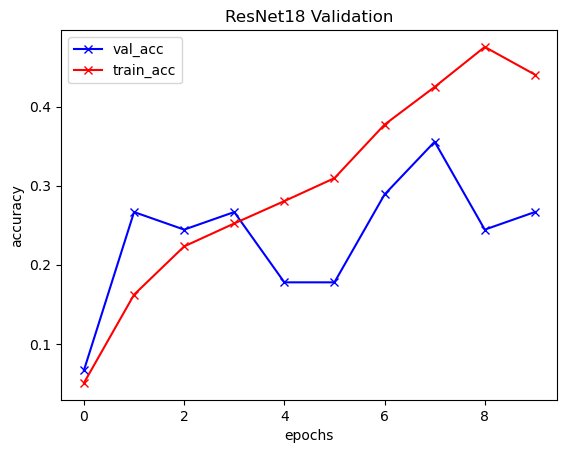

In [38]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_ResNet18_validation)))
for h in history_ResNet18_validation:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='val_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('ResNet18 Validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

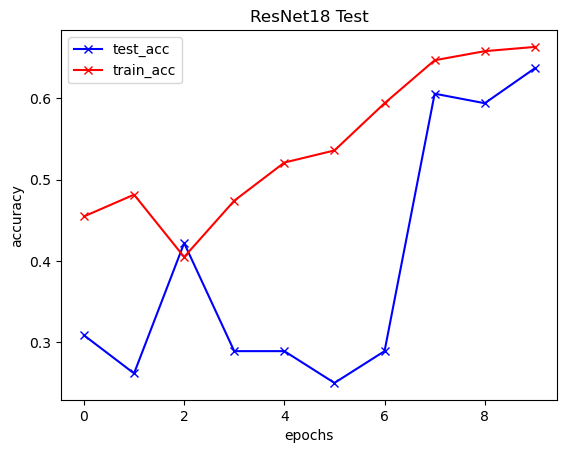

In [39]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_ResNet18_test)))
for h in history_ResNet18_test:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('ResNet18 Test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [40]:
# Task III.b

In [18]:
datasetSDD = ImageFolder('./SDDsubset')

In [19]:
len(datasetSDD)

1232

In [43]:
# many definitions omitted since breeds are the same across datasets; test,val and train sizes are not used, etc
# only need one dataset since we are instructed to test the entire dataset (against test DBI, so I used test transforms to keep it similar)
entire_datasetSDD = DogBreedDataset(datasetSDD, test_transform)
SDD_dl =  DataLoader(entire_datasetSDD, batch_size, num_workers=0, pin_memory=True)

modelResNet18SDD = DogBreedUntrainedResnet18()
modelResNet18SDD

# getting default device
device = get_default_device()
print(device)

# moving SDD dataloader to gpu
SDD_dl = DeviceDataLoader(SDD_dl, device)

# moving model to gpu
to_device(modelResNet18SDD, device)


cuda


DogBreedUntrainedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [44]:
# run the trained model on the entire SDD dataset (using what we trained before)
history_ResNet18_SDD = fit_one_cycle(num_epochs, max_lr, modelResNet18SDD, train_dl, SDD_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.2608, train_acc: 0.1295, val_loss: 3.0965, val_acc: 0.1555


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 2.1323, train_acc: 0.1696, val_loss: 1.9906, val_acc: 0.1359


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 1.8817, train_acc: 0.2314, val_loss: 2.1973, val_acc: 0.1805


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 1.7341, train_acc: 0.3177, val_loss: 2.0539, val_acc: 0.2141


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 1.6174, train_acc: 0.3728, val_loss: 2.2352, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 1.5958, train_acc: 0.3966, val_loss: 2.0409, val_acc: 0.2227


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 1.5314, train_acc: 0.4249, val_loss: 2.0134, val_acc: 0.2164


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 1.4386, train_acc: 0.4234, val_loss: 1.8904, val_acc: 0.2773


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 1.3990, train_acc: 0.4725, val_loss: 1.8880, val_acc: 0.3008


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 1.3727, train_acc: 0.5112, val_loss: 1.8781, val_acc: 0.3031


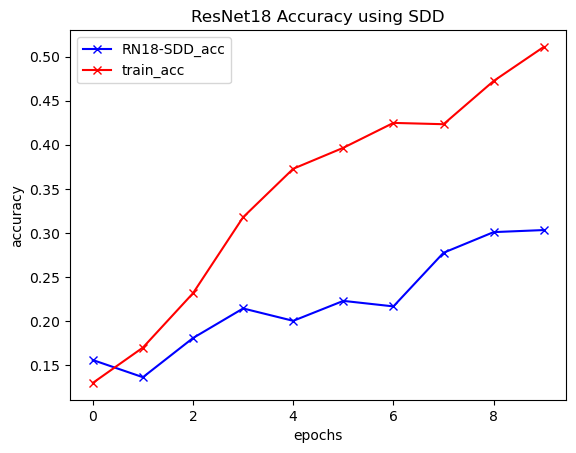

In [45]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_ResNet18_SDD)))
for h in history_ResNet18_SDD:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='RN18-SDD_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('ResNet18 Accuracy using SDD')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [46]:
# task IV

In [53]:
# error message saying to change pretrained to weights
# C:\Users\jaren\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and 
# may be removed in the future, please use 'weights' instead.
#   warnings.warn(
# C:\Users\jaren\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' 
# are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. 
# You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
#   warnings.warn(msg)
# Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jaren/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth

from torchvision.models import ResNet18_Weights

class DogBreedPretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [54]:
model_PRN18 = DogBreedPretrainedResnet18()
device = get_default_device()
to_device(model_PRN18, device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jaren/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 41.1MB/s]


DogBreedPretrainedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [55]:
history_PRN18 = fit_one_cycle(num_epochs, max_lr, model_PRN18, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.3203, train_acc: 0.0833, val_loss: 2.2863, val_acc: 0.4180


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.3478, train_acc: 0.6570, val_loss: 1.4607, val_acc: 0.6133


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.2929, train_acc: 0.9412, val_loss: 0.1695, val_acc: 0.9492


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.1484, train_acc: 0.9702, val_loss: 0.1374, val_acc: 0.9727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0592, train_acc: 0.9836, val_loss: 0.1057, val_acc: 0.9688


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0387, train_acc: 0.9911, val_loss: 0.1047, val_acc: 0.9609


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0447, train_acc: 0.9896, val_loss: 0.0924, val_acc: 0.9766


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0185, train_acc: 1.0000, val_loss: 0.0778, val_acc: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0245, train_acc: 0.9978, val_loss: 0.0725, val_acc: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0181, train_acc: 1.0000, val_loss: 0.0718, val_acc: 0.9805


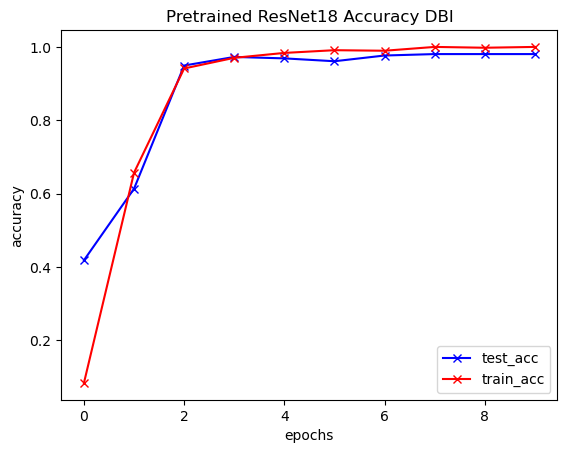

In [79]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_PRN18)))
for h in history_PRN18:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('Pretrained ResNet18 Accuracy DBI')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [58]:
from torchvision.models import ResNet34_Weights

class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [59]:
model_PRN34 = DogBreedPretrainedResnet34()
device = get_default_device()
to_device(model_PRN34, device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\jaren/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 72.9MB/s]


DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [60]:
history_PRN34 = fit_one_cycle(num_epochs, max_lr, model_PRN34, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.5869, train_acc: 0.0573, val_loss: 2.6160, val_acc: 0.2617


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.2800, train_acc: 0.7001, val_loss: 0.4109, val_acc: 0.9648


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.1682, train_acc: 0.9710, val_loss: 0.1233, val_acc: 0.9609


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0486, train_acc: 0.9866, val_loss: 0.0633, val_acc: 0.9883


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0292, train_acc: 0.9918, val_loss: 0.0515, val_acc: 0.9883


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0197, train_acc: 0.9933, val_loss: 0.0422, val_acc: 0.9883


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0246, train_acc: 0.9933, val_loss: 0.0388, val_acc: 0.9883


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0222, train_acc: 0.9918, val_loss: 0.0393, val_acc: 0.9844


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0111, train_acc: 0.9978, val_loss: 0.0387, val_acc: 0.9844


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0093, train_acc: 1.0000, val_loss: 0.0381, val_acc: 0.9844


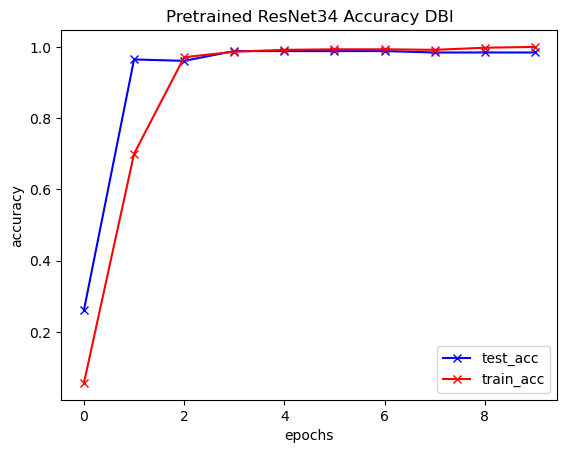

In [89]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_PRN34)))
for h in history_PRN34:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('Pretrained ResNet34 Accuracy DBI')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [75]:
'''
source for using this model:
https://pytorch.org/hub/pytorch_vision_resnext/

for whatever reason it seems pretrained=True works with this model
'''

class DogBreedPretrainedResNeXt32(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 32),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [76]:
model_PRNX32 = DogBreedPretrainedResNeXt32()
device = get_default_device()
to_device(model_PRNX32, device)

DogBreedPretrainedResNeXt32(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [77]:
history_PRNX32 = fit_one_cycle(num_epochs, max_lr, model_PRNX32, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.1570, train_acc: 0.1243, val_loss: 1.9874, val_acc: 0.3828


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.9542, train_acc: 0.8624, val_loss: 0.1402, val_acc: 0.9727


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0916, train_acc: 0.9844, val_loss: 0.0543, val_acc: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0453, train_acc: 0.9896, val_loss: 0.0352, val_acc: 0.9883


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0129, train_acc: 0.9978, val_loss: 0.0342, val_acc: 0.9766


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0164, train_acc: 0.9918, val_loss: 0.0274, val_acc: 0.9883


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0108, train_acc: 1.0000, val_loss: 0.0520, val_acc: 0.9766


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0067, train_acc: 0.9978, val_loss: 0.0556, val_acc: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0096, train_acc: 1.0000, val_loss: 0.0471, val_acc: 0.9805


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0037, train_acc: 1.0000, val_loss: 0.0440, val_acc: 0.9805


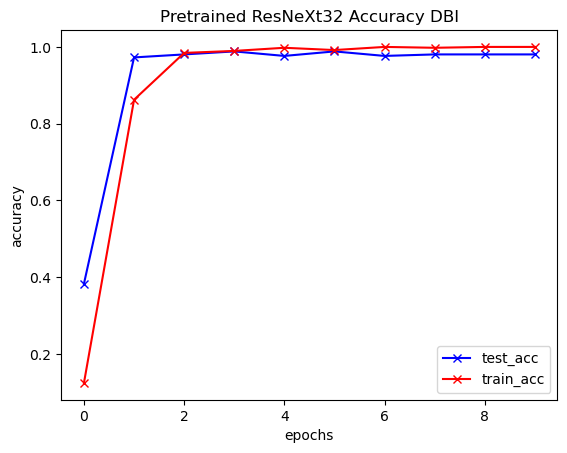

In [90]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_PRNX32)))
for h in history_PRNX32:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('Pretrained ResNeXt32 Accuracy DBI')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [80]:
model_PRN18SDD = DogBreedPretrainedResnet18()
device = get_default_device()
to_device(model_PRN18SDD, device)

DogBreedPretrainedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [81]:
history_PRN18SDD = fit_one_cycle(num_epochs, max_lr, model_PRN18SDD, train_dl, SDD_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.2808, train_acc: 0.0863, val_loss: 2.4245, val_acc: 0.2977


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.2694, train_acc: 0.6882, val_loss: 0.7642, val_acc: 0.8016


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.2584, train_acc: 0.9494, val_loss: 0.4915, val_acc: 0.8148


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.1328, train_acc: 0.9568, val_loss: 0.3064, val_acc: 0.9016


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0676, train_acc: 0.9844, val_loss: 0.4494, val_acc: 0.8422


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0383, train_acc: 0.9911, val_loss: 0.3582, val_acc: 0.8766


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0307, train_acc: 0.9933, val_loss: 0.3449, val_acc: 0.8820


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0205, train_acc: 0.9978, val_loss: 0.3723, val_acc: 0.8758


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0166, train_acc: 1.0000, val_loss: 0.3659, val_acc: 0.8789


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0169, train_acc: 1.0000, val_loss: 0.3612, val_acc: 0.8789


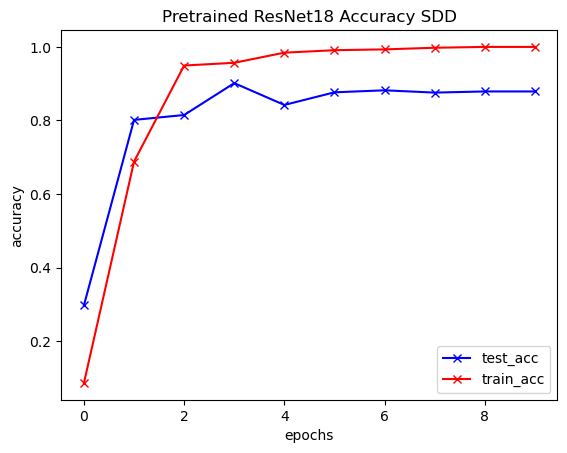

In [82]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_PRN18SDD)))
for h in history_PRN18SDD:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('Pretrained ResNet18 Accuracy SDD')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [83]:
model_PRN34SDD = DogBreedPretrainedResnet34()
device = get_default_device()
to_device(model_PRN34SDD, device)

DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [84]:
history_PRN34SDD = fit_one_cycle(num_epochs, max_lr, model_PRN34SDD, train_dl, SDD_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.3893, train_acc: 0.0781, val_loss: 2.3153, val_acc: 0.3078


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.1634, train_acc: 0.7262, val_loss: 0.6017, val_acc: 0.7945


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.1868, train_acc: 0.9621, val_loss: 0.3750, val_acc: 0.8633


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0761, train_acc: 0.9821, val_loss: 0.4036, val_acc: 0.8445


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0599, train_acc: 0.9836, val_loss: 0.3301, val_acc: 0.8867


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0262, train_acc: 0.9933, val_loss: 0.3512, val_acc: 0.8719


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0207, train_acc: 0.9978, val_loss: 0.2954, val_acc: 0.8984


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0130, train_acc: 0.9978, val_loss: 0.2763, val_acc: 0.9047


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0126, train_acc: 1.0000, val_loss: 0.2653, val_acc: 0.9078


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0188, train_acc: 1.0000, val_loss: 0.2695, val_acc: 0.9070


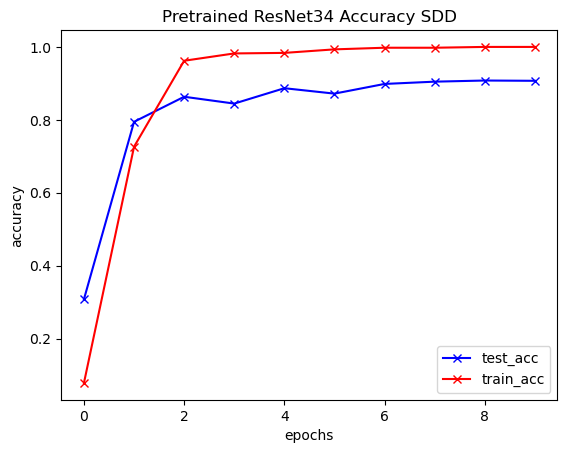

In [85]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_PRN34SDD)))
for h in history_PRN34SDD:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('Pretrained ResNet34 Accuracy SDD')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [86]:
model_PRNX32SDD = DogBreedPretrainedResNeXt32()
device = get_default_device()
to_device(model_PRNX32SDD, device)

DogBreedPretrainedResNeXt32(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [87]:
history_PRNX32SDD = fit_one_cycle(num_epochs, max_lr, model_PRNX32SDD, train_dl, SDD_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.2250, train_acc: 0.1228, val_loss: 1.9831, val_acc: 0.4781


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.0265, train_acc: 0.8534, val_loss: 0.2952, val_acc: 0.9250


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.1158, train_acc: 0.9740, val_loss: 0.3580, val_acc: 0.8805


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0219, train_acc: 1.0000, val_loss: 0.1860, val_acc: 0.9430


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0064, train_acc: 1.0000, val_loss: 0.1604, val_acc: 0.9430


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0051, train_acc: 1.0000, val_loss: 0.1364, val_acc: 0.9523


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0124, train_acc: 0.9940, val_loss: 0.1318, val_acc: 0.9594


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0087, train_acc: 0.9955, val_loss: 0.1753, val_acc: 0.9438


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0139, train_acc: 0.9940, val_loss: 0.1569, val_acc: 0.9484


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0062, train_acc: 1.0000, val_loss: 0.1452, val_acc: 0.9516


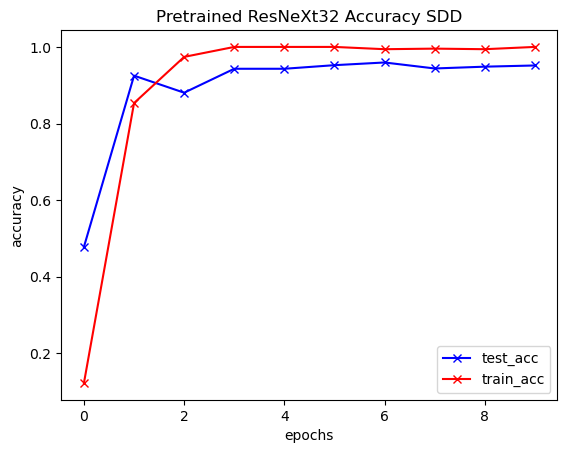

In [88]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(history_PRNX32SDD)))
for h in history_PRNX32SDD:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('Pretrained ResNeXt32 Accuracy SDD')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [91]:
# Task V

In [96]:
# implementation details are in my report, but basically I emptied all the elements out of the breeds folder and into just DBI or SDD
t5dataset = ImageFolder('./task5')

In [97]:
len(t5dataset)

1878

In [98]:
dataset_types = []

for n in t5dataset.classes:
    dataset_types.append(n)

dataset_types

['DBI_integrated', 'SDD_integrated']

In [99]:
# need to set up all of the elements again for the new dataset t5dataset
random_seed = 45
torch.manual_seed(random_seed);

test_pct = 0.3
test_size = int(len(t5dataset)*test_pct)
# leaving out validation set for simplicity, so the amounts are now:
# test size 30% validation size 0% train_size 70%
train_size = len(t5dataset) - test_size

train_size, test_size

(1315, 563)

In [100]:
train_ds, test_ds = random_split(t5dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(1315, 563)

0


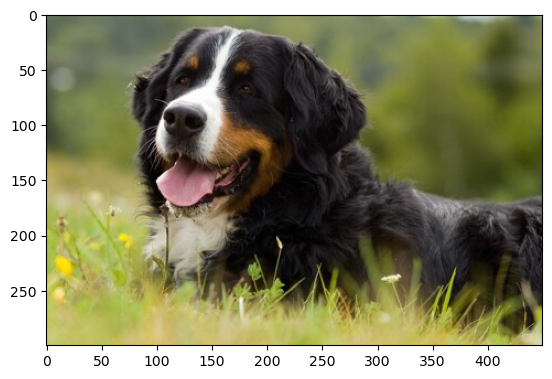

In [101]:
# test to make sure everything works so far
img, label = train_ds[6]
print(label)
plt.imshow(img)

0


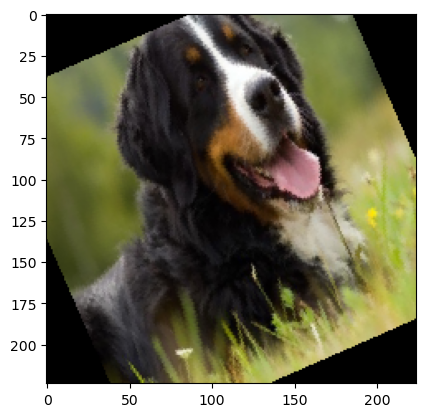

In [102]:
train_dataset = DogBreedDataset(train_ds, train_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

# test again
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [103]:
batch_size =64

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=0, pin_memory=True)

In [104]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader and test dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


cuda


In [105]:
# I am using the ResNet34 for these tests
modelTask5 = DogBreedPretrainedResnet34()
device = get_default_device()
to_device(modelTask5, device)

DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [106]:
historyTask5 = fit_one_cycle(num_epochs, max_lr, modelTask5, train_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.8905, train_acc: 0.4167, val_loss: 0.6818, val_acc: 0.6843


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.3971, train_acc: 0.8093, val_loss: 0.3944, val_acc: 0.8194


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.2684, train_acc: 0.8798, val_loss: 0.5292, val_acc: 0.7855


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.2956, train_acc: 0.8727, val_loss: 0.4442, val_acc: 0.8337


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.1985, train_acc: 0.9202, val_loss: 0.4956, val_acc: 0.8446


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.1783, train_acc: 0.9309, val_loss: 0.5098, val_acc: 0.8137


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0787, train_acc: 0.9741, val_loss: 0.4700, val_acc: 0.8389


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0741, train_acc: 0.9720, val_loss: 0.4978, val_acc: 0.8698


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0438, train_acc: 0.9851, val_loss: 0.4947, val_acc: 0.8507


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0316, train_acc: 0.9911, val_loss: 0.4864, val_acc: 0.8541


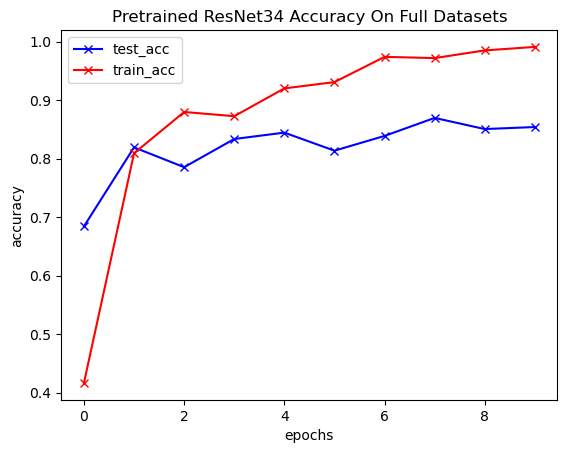

In [107]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
time = list(range(len(historyTask5)))
for h in historyTask5:
    val_loss.append(h['val_loss'])
    val_acc.append(h['val_acc'])
    train_loss.append(h['train_loss'])
    train_acc.append(h['train_acc'])
plt.plot(time, val_acc, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc, c='red', label='train_acc', marker='x')
plt.title('Pretrained ResNet34 Accuracy On Full Datasets')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [108]:
# end of file